Inspired by:

https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing

https://www.kaggle.com/gmhost/gru-capsule

https://arxiv.org/abs/1805.07882

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import gc
import numpy as np

import tensorflow as tf
import keras
from keras import layers, activations, models, optimizers, utils, regularizers, initializers
import keras.backend as backend
from keras.engine.input_layer import Input
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

DRIVE_PATH = "/content/gdrive/My Drive/Colab Notebooks/"
OUTPUT_PATH = "/content/gdrive/My Drive/Colab Notebooks/"
TRAIN_FILE = "datasets/train.csv"
TEST_FILE = "datasets/test.csv"
GLOVE_FILE = "embeddings/glove.840B.300d/glove.840B.300d.txt"
PARA_FILE = "embeddings/paragram_300_sl999/paragram_300_sl999.txt"
MODEL_SAVE_PATH = "models/QIQC_model.h5"
SUBMISSION_PATH = "submission.csv"

Using TensorFlow backend.


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def load_data(path = DRIVE_PATH, file = TRAIN_FILE):
    csv_path = os.path.join(path,file)
    return pd.read_csv(csv_path)

def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x 

def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])   
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])  
    return text

def questions_lengths(texts_sequences):
    lengths_list = [len(seq) for seq in texts_sequences]
    lengths = np.zeros(max(lengths_list)+1)
    for sequence in texts_sequences:
        lengths[len(sequence)] += 1
    perc_lengths = np.cumsum(lengths)/np.sum(lengths)
    return lengths, perc_lengths

def load_glove(word_index, drive = DRIVE_PATH, gloveFile = GLOVE_FILE, embed_size = 300):
    max_features = len(word_index)+1
    EMBEDDING_FILE = os.path.join(drive,gloveFile)
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

def load_para(word_index, drive = DRIVE_PATH, paraFile = PARA_FILE, embed_size = 300):
    max_features = len(word_index)+1
    EMBEDDING_FILE = os.path.join(drive,paraFile)
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100 and o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

def split_data(data, targets, dv, cv):
    data_targets = np.c_[data, targets]
    targets_idx = data_targets.shape[1]-1
    positive_data_targets = data_targets[data_targets[:,targets_idx]==1]
    negative_data_targets = data_targets[data_targets[:,targets_idx]==0]
    
    positive_length = len(positive_data_targets)
    negative_length = len(negative_data_targets)
    total_length = positive_length + negative_length
    pos_data_targets = positive_data_targets[np.random.permutation(positive_length), :]
    neg_data_targets = negative_data_targets[np.random.permutation(negative_length), :]
    
    if dv != 0:
        dv_positive = int(dv * positive_length/(positive_length + negative_length))
        dv_negative = dv - dv_positive
        dv_data_targets = np.concatenate((positive_data_targets[0:dv_positive,:], negative_data_targets[0:dv_negative,:]))
        dv_data_targets = dv_data_targets[np.random.permutation(dv), :]
        y_dev = dv_data_targets[:,targets_idx].astype(float)
        X_dev = dv_data_targets[:,:targets_idx]
    else:
        dv_positive = 0
        dv_negative = 0
        
    if cv != 0:
        cv_positive = int(cv * positive_length/(positive_length + negative_length))
        cv_negative = cv - cv_positive
        cv_data_targets = np.concatenate((positive_data_targets[dv_positive:dv_positive + cv_positive,:], negative_data_targets[dv_negative:dv_negative + cv_negative,:]))
        cv_data_targets = cv_data_targets[np.random.permutation(cv), :]
        y_cross = cv_data_targets[:,targets_idx].astype(float)
        X_cross = cv_data_targets[:,:targets_idx]
    else:
        cv_positive = 0
        cv_negative = 0
        
    train_data_targets = np.concatenate((positive_data_targets[dv_positive + cv_positive:,:], negative_data_targets[dv_negative + cv_negative:,:]))
    train_data_targets = train_data_targets[np.random.permutation(total_length-dv-cv), :]
    y_train = train_data_targets[:,targets_idx].astype(float)
    X_train = train_data_targets[:,:targets_idx]
    
    if cv == 0 and dv == 0:
        return X_train, y_train
    elif cv == 0 and dv != 0:
        return X_train, y_train, X_dev, y_dev
    elif cv != 0 and dv == 0:
        return X_train, y_train, X_cross, y_cross
    else:
        return X_train, y_train, X_dev, y_dev, X_cross, y_cross

In [0]:
class QIQCSequence(utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, seed=42):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.seed = seed
        self.indexes = np.arange(len(self.y))
        np.random.seed(seed)

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def __getitem__(self, idx): 
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]        
            
        return np.array(batch_x), np.array(batch_y)

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.thresholds = []
        self.val_recalls = []
        self.val_precisions = []
        self.min_loss = np.inf
        self.best_threshold = 0.5
        
    def __f1_smart(self, y_true, y_pred):
        args = np.argsort(y_pred)[::-1] #arguments of y_pred to sort it in decreasing order
        y_pre = y_pred[args]
        y_tru = y_true[args]
        cumul_preds_pos = np.cumsum(np.ones_like(y_pre))
        cumul_true_pos = np.cumsum(y_tru)
        total_pos = y_tru.sum() * np.ones_like(y_true)
        
        true_pos = cumul_true_pos
        false_pos = cumul_preds_pos - cumul_true_pos
        false_neg = total_pos - cumul_true_pos
        
        f1s = 2*true_pos/(2*true_pos + false_pos + false_neg)
        prec = true_pos/(true_pos + false_pos)
        rec = true_pos/(true_pos + false_neg)
        res_idx = np.argmax(f1s)
        return f1s[res_idx], prec[res_idx], rec[res_idx], y_pre[res_idx]

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0])))
        val_targ = self.validation_data[1]
        _val_f1, _val_precision, _val_recall, _best_threshold = self.__f1_smart(np.squeeze(val_targ), np.squeeze(val_predict))
        _val_f1_O5 = f1_score(np.squeeze(val_targ), np.squeeze(val_predict.round()))
        self.val_f1s.append(_val_f1)
        self.thresholds.append(_best_threshold)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        epoch_loss = logs['val_loss']
        if epoch_loss < self.min_loss:
            self.best_threshold = _best_threshold
            self.min_loss = epoch_loss
            _saved = " saved"
        else:
            _saved = ""
        print("")
        print("f1 (threshold 0.5): {:.4f} — f1 (threshold {:.4f}{}): {:.4f}; precision: {:.4f}; recall: {:.4f}".format(_val_f1_O5, _best_threshold, _saved, _val_f1, _val_precision, _val_recall))
        return

class LR_finder(Callback):
    def __init__(self, min_lr=1.0e-7, max_lr=1.0, method="exp"):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.method = method
        
    def on_train_begin(self, logs={}):
        self.total_steps = self.params['steps'] * self.params['epochs']
        if self.method == "exp":
            self.base = np.power((self.max_lr/self.min_lr),1/(self.total_steps -1))
        else:
            self.base = (self.max_lr - self.min_lr)/(self.total_steps -1)
        self.lr_sched = self.min_lr
        self.losses = []
        self.lr_list = []
        return
    
    def on_batch_begin(self, batch, logs={}):
        backend.set_value(self.model.optimizer.lr, self.lr_sched)
        return
        
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs['loss'])
        self.lr_list.append(self.lr_sched)
        if self.method == "exp":
            self.lr_sched *= self.base
        else:
            self.lr_sched += self.base
        return
    
    def plot_lr_curve(self):
        plt.figure(figsize = (16, 10))
        plt.plot(self.lr_list)
        plt.xlabel("steps")
        plt.ylabel("lr")
        plt.show()
    
    def __ewma_vectorized(self, data, alpha):
        alpha_ = 1-alpha
        D = pd.DataFrame(data)
        M = D.ewm(alpha=alpha_).mean()
        out = M.values
        return out
    
    def plot_lr_search(self, alpha=0.99):
        plot_y = self.__ewma_vectorized(self.losses, alpha)
        plt.figure(figsize = (16, 10))
        plt.xscale("log")
        plt.plot(self.lr_list, plot_y)
        if max(plot_y)> 4.0 : plt.ylim((0.0,4.0))
        plt.xlabel("log lr")
        plt.ylabel("loss")
        plt.show()
        
class LR_cos_scheduler(Callback):

    def __init__(self, scale_factor=10, set_min=None,period=1): 
        self.scale_factor = scale_factor
        self.set_min = set_min
        self.period =  period       
        
    def on_train_begin(self, logs={}):
        self.step = 0
        self.nb_steps = 0
        self.frequency = np.pi/(self.period*self.params['steps'])
        self.max_lr = backend.get_value(self.model.optimizer.lr)
        self.saved_lr = backend.get_value(self.model.optimizer.lr)
        if self.set_min == None:
            self.min_lr = self.max_lr/self.scale_factor
        else:
            self.min_lr = self.set_min
        self.amplitude_lr = (self.max_lr - self.min_lr)/2
        self.lr_stack = []
        return
    
    def on_epoch_begin(self, epoch, logs={}):
        if epoch % self.period == 0:     
            self.step = 0
        return
    
    def on_train_end(self, epoch, logs={}):    
        backend.set_value(self.model.optimizer.lr, self.saved_lr)
        return
    
    def on_batch_begin(self, batch, logs={}):
        learning_rate = self.amplitude_lr * np.cos(self.step * self.frequency) + self.amplitude_lr + self.min_lr
        backend.set_value(self.model.optimizer.lr, learning_rate)
        self.lr_stack.append(learning_rate)
        self.nb_steps+=1
        self.step+=1
        return

    def plot_lr_schedule(self):
        plt.figure(figsize = (16, 10))
        plt.plot(np.arange(self.nb_steps), self.lr_stack)
        plt.xlabel("#steps")
        plt.ylabel("lr schedule")

class loss_log(Callback):
    def on_train_begin(self, logs={}):
        self.min_loss = np.inf
        self.best_train_loss = []
        self.best_val_loss = []
        self.train_loss_stack = []
        self.nb_steps = 0
        return

    def on_batch_end(self, batch, logs={}):
        self.train_loss_stack.append(logs['loss'])
        self.nb_steps+=1
        return
    
    def on_epoch_end(self, epoch, logs={}):
        val_loss = logs['val_loss']
        train_losses = self.__ewma_vectorized(self.train_loss_stack, alpha=0.99)
        self.best_train_loss.append(train_losses[-1])
        self.best_val_loss.append(val_loss)
        return
      
    def __ewma_vectorized(self, data, alpha):
        alpha_ = 1-alpha
        D = pd.DataFrame(data)
        M = D.ewm(alpha=alpha_).mean()
        out = M.values
        return out
      
    def plot_train_loss(self, alpha=0.99):
        plot_y = self.__ewma_vectorized(self.train_loss_stack, alpha)
        plt.figure(figsize = (16, 10))
        plt.plot(np.arange(self.nb_steps), plot_y)
        if max(plot_y)> 4.0 : plt.ylim((0.0,4.0))
        plt.xlabel("#steps")
        plt.ylabel("train loss")
        plt.show()

# Data loading and preparation

In [6]:
train_data = load_data()
test_data = load_data(file = TEST_FILE)
print("Train shape : ", train_data.shape)
print("Test shape : ", test_data.shape)

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "euro", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "pound", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [0]:
train_data["question_text"] = train_data["question_text"].str.lower()
test_data["question_text"] = test_data["question_text"].str.lower()

train_data["question_text"] = train_data["question_text"].apply(lambda x: clean_contractions(x, contraction_mapping))
test_data["question_text"] = test_data["question_text"].apply(lambda x: clean_contractions(x, contraction_mapping))

train_data["question_text"] = train_data["question_text"].apply(lambda x: clean_special_chars(x, punct, punct_mapping))
test_data["question_text"] = test_data["question_text"].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

In [9]:
sub = {}
embed_size = 300 # how big is each word vector
total_embed_size = 2 * embed_size
max_features = None # how many unique words to use (i.e num rows in embedding vector)
n_steps = 100 # max number of words in a question to use #99.99%

## fill up the missing values
X_pd = train_data["question_text"].fillna("_na_")
X = X_pd.values
X_test_pd = test_data["question_text"].fillna("_na_")
X_test = X_test_pd.values
X_total = np.concatenate((X,X_test), axis=0)

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters='')
tokenizer.fit_on_texts(list(X_total))
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)

x_lengths, x_pc_lengths = questions_lengths(X)
x_test_lengths, x_test_pc_lengths = questions_lengths(X_test)

## Pad the sentences 
data = pad_sequences(X, maxlen=n_steps,truncating='post')
test_set = pad_sequences(X_test, maxlen=n_steps, truncating='post')

## Get the target values
targets = train_data['target'].values

sub['qid'] = test_data['qid']

del train_data, test_data, X_pd, X_test_pd
gc.collect()

14

In [10]:
x_pc_lengths[100], x_test_pc_lengths[100]

(0.9999754999915781, 0.999929040269647)

In [0]:
glove_matrix = load_glove(word_index)
para_matrix = load_para(word_index)
embedding_matrix = np.c_[glove_matrix,para_matrix]

# Model Construction:
1. Creates new embeddings out of two thanks to convolution
2. Creates sentence representation with maxpooling of convolution results
3. Creates second sentence representation with GRU on constructed embeddings
4. Concatenates the two sentence representations and pass them to 2-layer perceptron then to sigmoid for prediction

# Prepares training batches and validation set

In [12]:
reset_graph()
n_fc = [100,100,100,1]
window_width = 1
out_channels = embed_size
activation = activations.elu

lambda_ = 0.001
dr_ = 0.5
lr = 0.001
lr_low = lr/4

input_ = Input(shape=(n_steps,))

embedding = layers.Embedding(len(word_index)+1, total_embed_size, input_length=n_steps, weights=[embedding_matrix], trainable=False)(input_)# m x n_steps x 600
embedding = layers.Reshape((n_steps,total_embed_size,1))(embedding) # m x n_steps x total_embed_size x 1

#conv_1: m x n_steps x 1 x out_channels
conv_1 = layers.Conv2D(out_channels, (window_width, total_embed_size), activation=activation, kernel_initializer=initializers.he_normal(seed=12300),kernel_regularizer=regularizers.l2(lambda_))(embedding)
#mp_1: m x 1 x 1 x out_channels
mp_1 = layers.MaxPooling2D(pool_size=((n_steps-window_width+1),1))(conv_1)
#rs_1: m x out_channels
rs_1 = layers.Reshape((out_channels,))(mp_1)

#gru: m x out_channels
gru = layers.CuDNNGRU(units=out_channels,kernel_initializer=initializers.glorot_normal(seed=12300), recurrent_initializer=initializers.orthogonal(gain=1.0, seed=10000),kernel_regularizer=regularizers.l2(lambda_))(layers.Reshape((n_steps-window_width+1,out_channels))(conv_1))

#merged: m x 2*out_channels
merged = layers.concatenate([rs_1, gru], axis=1)
#merged = layers.Dropout(dr_)(merged)

fc = layers.Dense(n_fc[0], activation=activation, kernel_initializer=initializers.he_normal(seed=12300))(merged)#kernel_regularizer=regularizers.l2(lambda_)
fc = layers.Dropout(dr_)(fc)
fc = layers.Dense(n_fc[1], activation=activation, kernel_initializer=initializers.he_normal(seed=12400))(fc)
fc = layers.Dropout(dr_)(fc)
fc = layers.Dense(n_fc[2], activation=activation, kernel_initializer=initializers.he_normal(seed=12500))(fc)
fc = layers.Dropout(dr_)(fc)

out = layers.Dense(n_fc[3], activation='sigmoid', kernel_initializer=initializers.he_normal(seed=12600))(fc)

model = models.Model(inputs=input_, outputs=out)
optimizer = optimizers.Adam(lr=lr)

metrics = Metrics()
checkpoint = ModelCheckpoint(os.path.join(OUTPUT_PATH,MODEL_SAVE_PATH), monitor='val_loss', verbose=2, save_best_only=True, mode='min')
lr_scheduler = LR_cos_scheduler(set_min=lr_low)
lr_finder = LR_finder(method="lin")
loss_logger = loss_log()

model.compile(loss='binary_crossentropy',optimizer=optimizer)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 600)     120380400   input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 600, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)    

In [0]:
X_train, y_train, X_dv, y_dv = split_data(data, targets, dv=10000, cv=0)

batch_size = 1024 #64

QIQC_train = QIQCSequence(X_train, y_train, batch_size=batch_size)
QIQC_dev = QIQCSequence(X_dv, y_dv, batch_size=2000)
X_dev, y_dev = QIQC_dev.__getitem__(0)

# Training

In [0]:
#n_epochs = 5
#model.fit_generator(QIQC_train, epochs=n_epochs, verbose=1, validation_data=(X_dev, y_dev), callbacks=[lr_finder])

In [0]:
#lr_finder.plot_lr_curve()

In [0]:
#lr_finder.plot_lr_search()

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1266/1266 [==============================] - 613s 484ms/step - loss: 0.2344 - val_loss: 0.1264

f1 (threshold 0.5): 0.6311 — f1 (threshold 0.1784 saved): 0.6758; precision: 0.6226; recall: 0.7388

Epoch 00001: val_loss improved from inf to 0.12635, saving model to /content/gdrive/My Drive/Colab Notebooks/models/QIQC_model.h5
Epoch 2/10
1266/1266 [==============================] - 607s 480ms/step - loss: 0.1258 - val_loss: 0.1198

f1 (threshold 0.5): 0.6667 — f1 (threshold 0.1966 saved): 0.6835; precision: 0.5934; recall: 0.8060

Epoch 00002: val_loss improved from 0.12635 to 0.11982, saving model to /content/gdrive/My Drive/Colab Notebooks/models/QIQC_model.h5
Epoch 3/10
1266/1266 [==============================] - 606s 479ms/step - loss: 0.1215 - val_loss: 0.1191

f1 (threshold 0.5): 0.6557 — f1 (threshold 0.2594 saved): 0.6846; precision: 0.6220; recall: 0.7612

Epoch 00003: val_loss improved from 0.11982 to 0.11909, saving m

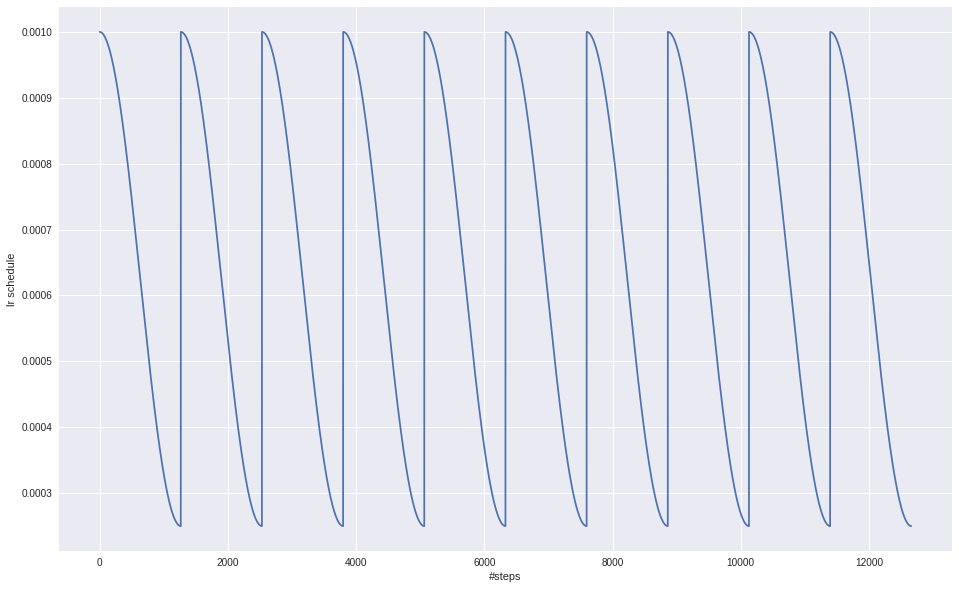

In [17]:
n_epochs = 10
model.fit_generator(QIQC_train, epochs=n_epochs, verbose=1, validation_data=(X_dev, y_dev), callbacks=[metrics, checkpoint, lr_scheduler, loss_logger])
lr_scheduler.plot_lr_schedule()

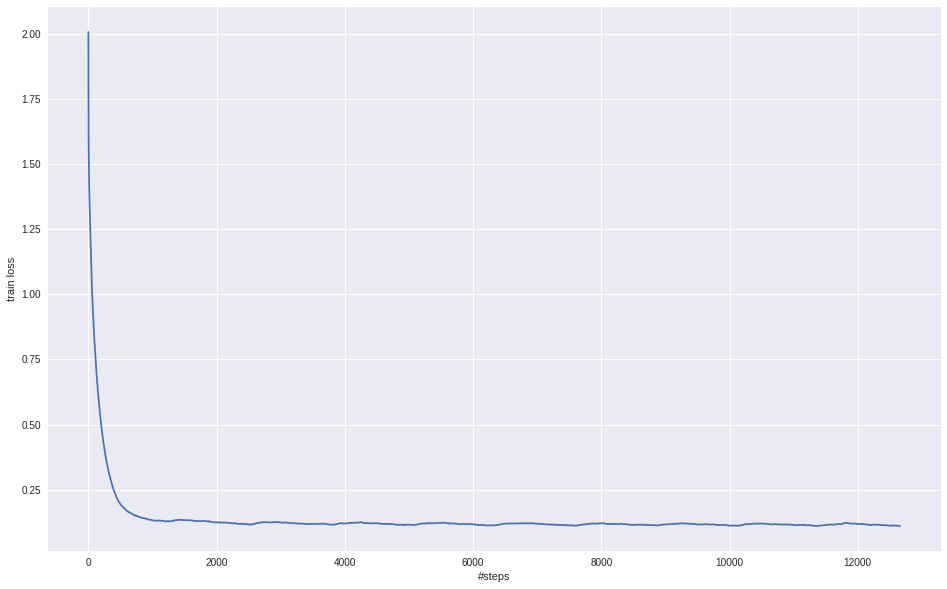

In [18]:
loss_logger.plot_train_loss()

In [19]:
"""y_test = np.squeeze(model.predict([test_set], batch_size=1024, verbose=2))
y_test = y_test.reshape((-1, 1))
pred_test_y = (y_test>=metrics.best_threshold).astype(int)
sub['prediction'] = np.squeeze(pred_test_y)
pd.DataFrame.from_dict(sub).to_csv("submission.csv", index=False)"""

'y_test = np.squeeze(model.predict([test_set], batch_size=1024, verbose=2))\ny_test = y_test.reshape((-1, 1))\npred_test_y = (y_test>=metrics.best_threshold).astype(int)\nsub[\'prediction\'] = np.squeeze(pred_test_y)\npd.DataFrame.from_dict(sub).to_csv("submission.csv", index=False)'